# <span style='color:SteelBlue'>PB5 - Segmentation_clients_e-commerce (part 3)</span>

<img src="https://asset.brandfetch.io/idvSn4Org5/idCJV4h5Ot.png" width="400" height="400">

# <span style='background:white; color:black'>Sommaire</span>

**Introduction**

Importations des librairies utilisées dans ce notebook

Paramètres d'affichage du notebook

Fonctions utilisées dans ce notebook

Importation des données

**Etape 1 : Création des datasets par plage temporelles**
- _1/ Nettoyage récence_
- _2/ Détermination des plages temporelles_
- _3/ Création des datasets des plages temporelles_

**Etape 2 : Clustering période de référence**

**Etape 3 : Prédictions des clusters des nouveaux clients**
- _1/ Prédictions à partir du modèle de référence_
- _2/ Prédictions à partir des modèles entrainés sur la plage correspondante_

**Etape 4 : Analyse de l'obsolescence du clustering**
- _1/ Calcul de l'ARI_
- _2/ Visualisation de l'ARI_

**Conclusion**

# <span style='background:blue'>Introduction</span>

Olist souhaite que nous fournissons à ses équipes d'e-commerce une
segmentation des clients qu’elles pourront utiliser au quotidien pour leurs
campagnes de communication.

Nous devons fournir à l’équipe Marketing une description actionable de votre
segmentation et de sa logique sous-jacente pour une utilisation optimale,
ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la
stabilité des segments au cours du temps.
___

**Mission**

**Réaliser la segmentation des clients en utilisant des méthodes**
**non-superviséees**. Notre objectif est de comprendre les différents types
d’utilisateurs grâce à leur comportement et à leurs données personnelles.
Pour cela nous devons :
1. Réaliser une courte analyse exploratoire.
2. Tester différents modèles de segmentation afin de répondre au mieux à la
problématique.
3. Créer une proposition de contrat de maintenance basée sur une analyse de
la stabilité des segments au cours du temps.

Ce notebook présente la 3ème partie. Nous réalisons une simulation pour
déterminer la stabilité des segments au cours du temps pour émettre une
proposition de fréquence de maintenance au cours du temps.
___

**Source des datasets**<br>

Olist nous fournit une base de données anonymisée comportant des informations
sur l’historique de commandes, les produits achetés, les commentaires de
satisfaction, et la localisation des clients depuis janvier 2017.

Ce dataset a été nettoyé et enrichi dans le notebook 1. Le clustering a été
implémenté dans le notebook 2. Nous allons donc utiliser le dataset issu du
notebook 2 pour réaliser la segmentation des clients.

nom du fichier : **olist_clients_segmentation_kmeans_rfms.csv**

# <span style='background:grey'>Importations des librairies utilisées dans ce notebook</span>

In [1]:
# Librairies générales
import os.path
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import time
from IPython.display import display
import scipy
from datetime import datetime
import sklearn

# K-means
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# ARI
from sklearn.metrics import adjusted_rand_score

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print("Version des librairies utilisées :")
print("Python        : " + sys.version)
print("Matplotlib    : " + mpl.__version__)
print("NumPy         : " + np.version.full_version)
print("Pandas        : " + pd.__version__)
print("Scipy         : " + scipy.__version__)
print("Seaborn       : " + sns.__version__)
print("Sklearn       : " + sklearn.__version__)

# Afficher heure lancement
maintenant = datetime.now().isoformat()
print("\nCode lancé le : " + maintenant)

# Enregistrer l'heure de début
start_time = time.time()

# Activer la verification PEP8
print("")
%load_ext pycodestyle_magic
%pycodestyle_on

Version des librairies utilisées :
Python        : 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]
Matplotlib    : 3.8.2
NumPy         : 1.26.2
Pandas        : 2.1.4
Scipy         : 1.11.4
Seaborn       : 0.13.0
Sklearn       : 1.3.2

Code lancé le : 2023-12-23T10:39:07.389722



<div class="alert alert-block alert-warning"><b>Formattage du notebook au PEP8 => lancer cette ligne de code dans le terminal VSC : </b> nbqa black Berthe_Pierrick_3_notebook_simulation_112023.ipynb</div>

# <span style='background:grey'>Paramètres d'affichage du notebook</span>

In [2]:
# paramétrage des paramètres d'affichage dans le notebook (pour afficher les
# définitions des indicateurs)
pd.set_option("display.max_row", 100)
pd.set_option("display.max_column", 100)
pd.set_option("display.precision", 5)

# Création d'1 palette de couleurs
colors_list = [
    "Gold",
    "MediumPurple",
    "DarkOrange",
    "LimeGreen",
    "Tomato",
    "SteelBlue",
    "SaddleBrown",
    "DeepPink",
]

# Définit le style de la police pour le titre des graphiques
font_title = {
    "family": "Times New Roman",
    "color": "000000",  # Noir en notation hexadécimale
    "size": 22,
}

# Définit le style de la police pour les axes du graphique
font_axe = {
    "family": "Times New Roman",
    "color": "000000",  # Noir en notation hexadécimale
    "size": 16,
}

# <span style='background:grey'>Fonctions utilisées dans ce notebook</span>

In [3]:
# #                            DETECTER_TROUS
# # **************************************************************************

def detecter_trous(nbr_client):
    """
    Cette fonction détecte les "trous", c'est-à-dire les jours avec une
    occurrence nulle et agglomère les trous consécutifs.

    Args:
        nbr_client (numpy.array): Un tableau numpy contenant le nombre de
        clients par jour.

    Returns:
        list: Une liste de tuples, où chaque tuple contient le début et la fin
        d'un "trou".
    """

    # Trouver les "trous" en cherchant les jours avec une occurence nulle
    indices = np.where(nbr_client == 0)[0]

    # Agglomérer les trous consécutifs
    trou_par_jour = []
    start = indices[0]
    for i in range(1, len(indices)):
        if indices[i] != indices[i - 1] + 1:
            trou_par_jour.append((start, indices[i - 1] - 1))
            start = indices[i]
    trou_par_jour.append((start, indices[-1 - 1]))

    # output
    return trou_par_jour

In [4]:
# #                            CREER_PLAGES
# # **************************************************************************

def creer_plages(plage_reference, nbr_jour_plage):
    """
    Cette fonction crée des plages en retranchant un certain nombre de jours à
    chaque jour de fin.

    Args:
        plage_reference (tuple): Un tuple contenant le jour de fin et le jour
        de début de la plage de référence.
        nbr_jour_plage (int): Le nombre de jours à retrancher à chaque jour de
        fin.

    Returns:
        DataFrame: Un DataFrame contenant les jours de fin et de début de
        chaque plage.
    """

    # Créer un DataFrame à partir de la plage de référence
    df_plages = pd.DataFrame(
        [plage_reference],
        columns=["jour_fin", "jour_debut"]
    )

    # Créer des plages en retranchant nbr_jour_plage jours à chaque jour de fin
    plages = []
    start, end = plage_reference
    while start >= 0:
        plages.append((start, end))
        start -= nbr_jour_plage

    # Créer un DataFrame à partir des plages
    df_plages = pd.DataFrame(plages, columns=["jour_fin", "jour_debut"])

    # output
    return df_plages

In [5]:
# #                            CREER DATASETS
# # **************************************************************************

def creer_datasets(df_plages, df_data_filtered):
    """
    Cette fonction crée un dictionnaire de datasets pour chaque plage de temps.

    Args:
        df_plages (DataFrame): Un DataFrame contenant les jours de début et de
        fin pour chaque plage de temps.
        df_data_filtered (DataFrame): Le DataFrame original à découper.

    Returns:
        dict: Un dictionnaire où chaque clé est une plage de temps et chaque
        valeur est un DataFrame correspondant à cette plage.
    """

    # Créer un dictionnaire pour stocker les datasets pour chaque plage de
    # temps
    datasets = {}

    # Itérer sur les lignes du DataFrame df_plages
    for index, row in df_plages.iterrows():

        # Extraire les jours de début et de fin pour la plage de temps
        end_day = row["jour_fin"]
        start_day = row["jour_debut"]

        # Découper le df original en fonction des jours de début et de fin
        dataset = df_data_filtered[
            (df_data_filtered["recence"] <= start_day)
            & (df_data_filtered["recence"] > end_day)
        ]

        # Stocker dataset dans le dictionnaire avec la plage de temps en clé
        datasets[f"Plage_{index}"] = dataset

    # output
    return datasets

In [28]:
# #                            AFFICHER_ARI
# # **************************************************************************

def afficher_ARI(semaine, scores, seuil, font_title, font_axe):
    """
    Cette procédure crée et affiche un graphique à lignes montrant l'évolution
    du score ARI au cours du temps.

    Args:
        semaine (list): La liste des semaines.
        scores (list): La liste des scores ARI correspondants.
        seuil (float): Le seuil à indiquer sur le graphique.
        font_title (dict): Le dictionnaire des paramètres de police pour le
        titre.
        font_axe (dict): Le dictionnaire des paramètres de police pour les
        axes.

    Returns:
        None
    """

    # Créer un graphique à lignes
    plt.figure(figsize=(10, 6))
    plt.plot(semaine, scores, marker="o")

    # Ajouter une ligne horizontale au seuil de 0.7
    plt.axhline(y=seuil, color="r", linestyle="--")

    # Ajouter des titres et des labels
    plt.title("Evolution du score ARI au cours du temps", fontdict=font_title)
    plt.xlabel("semaine", fontdict=font_axe)
    plt.ylabel("Score ARI", fontdict=font_axe)

    # Afficher le graphique
    plt.show()

In [7]:
# #                            CALCULER_DUREE_NOTEBOOK
# # **************************************************************************

def calculer_duree_notebook(start_time):
    """
    Cette procédure calcule et affiche la durée totale depuis un temps de
    début donné.

    Args:
        start_time (float): Le temps de début en secondes depuis l'époque.

    Returns:
        None
    """

    # Calculer la durée totale
    total_time = time.time() - start_time

    # Convertir en minutes et secondes
    minutes, seconds = divmod(total_time, 60)

    # Afficher la durée totale
    message = (
        "Durée totale pour faire tourner le notebook : "
        "{0} minute(s) {1} seconde(s)"
    )
    print(message.format(int(minutes), int(seconds)))

# <span style='background:grey'>Importation des données</span>

Importation du fichiers CSV avec Pandas

In [8]:
# Définir le chemin
chemin = "./data/cleaned/"

# Obtenir une liste de tous les fichiers dans le répertoire
fichiers = os.listdir(chemin)

# Initialiser un dictionnaire vide
data_brut = {}

# Obtenir le dernier fichier
fichier = fichiers[-1]
print("===> Fichier importé: <====\n")
print(fichier)

# Traiter uniquement si le fichier est .csv
if fichier.endswith(".csv"):

    # Lire le fichier csv et le stocker dans le dictionnaire
    data_brut[fichier] = pd.read_csv(
        chemin + fichier,
        sep="\t",
        encoding="utf-8",
        index_col="customer_unique_id"
    )

===> Fichier importé: <====

olist_clients_segmentation_kmeans_rfms.csv


Nous isolons le contenu du fichier dans un dataframe (sans les clusters). 

In [9]:
# Fichier un df
df_data_avec_cluster = data_brut[fichier]

# Afficher aperçu et dimension du df
display("Aperçu du df importé:")
display(df_data_avec_cluster.head(3))
display(df_data_avec_cluster.shape)

# Suppression de la col des clusters
df_data = df_data_avec_cluster.drop("Cluster", axis=1)

# Afficher aperçu et dimension du df
display("Aperçu du df après suppression de la feature des clusters:")
display(df_data.head(3))
display(df_data.shape)

'Aperçu du df importé:'

,recence,frequence,montant,satisfaction,Cluster
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,5.0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,4.0,0
0000f46a3911fa3c0805444483337064,541,1,86.22,3.0,3


(94720, 5)

'Aperçu du df après suppression de la feature des clusters:'

,recence,frequence,montant,satisfaction
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,4.0
0000f46a3911fa3c0805444483337064,541,1,86.22,3.0


(94720, 4)

Nous affichons le nombre de valeurs manquantes par feature.

In [10]:
df_data.isna().sum()

recence         0
frequence       0
montant         0
satisfaction    0
dtype: int64

Nous vérifions le nombre de doublons sur l'index des clients.

In [11]:
# doublon sur les index
df_data.index.duplicated().sum()

0

Il n'y a aucune valeur manquante dans le dataframe et aucun doublon sur l'index des clients.

# <span style='background:blue'>Etape 1 : Création des datasets par plage temporelles</span>

## <span style='background:yellow; color:black'>1/ Nettoyage récence</span>

Nous observons les statistiques descriptives de la récence des clients.

In [12]:
#  Afficher les stats de la recence
stats = df_data["recence"].describe()
display(stats)

count    94720.00000
mean       242.43782
std        153.16371
min          0.00000
25%        118.00000
50%        223.00000
75%        352.00000
max        728.00000
Name: recence, dtype: float64

Nous visualisons la distribution de la récence des clients pour chaque jour
(728 jours).

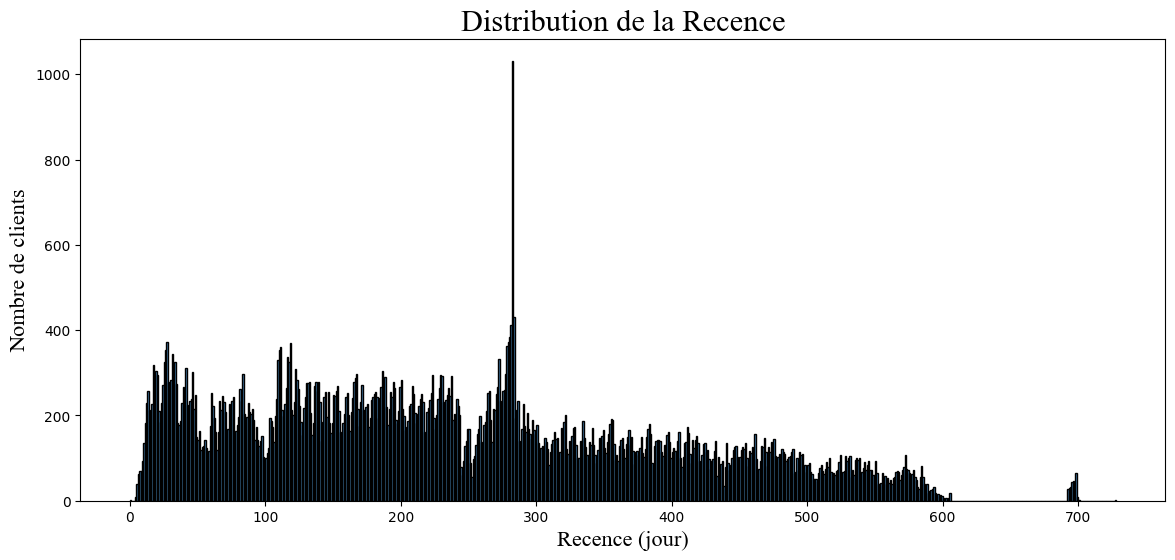

In [13]:
# Distribution de la récence
plt.figure(figsize=(14, 6))
nbr_client, jour, patches = plt.hist(
    df_data["recence"],
    bins=int(stats["max"]),
    color="steelblue",
    edgecolor="black"
)

# Titres du graphique et des axes
plt.xlabel("Recence (jour)", fontdict=font_axe)
plt.ylabel("Nombre de clients", fontdict=font_axe)
plt.title("Distribution de la Recence", fontdict=font_title)
plt.show()

Nous inspectons les trous dans la distribution de la récence des clients
pour réperer les dates avec aucune commande. 

In [14]:
# Détecter les trous
trou_par_jour = detecter_trous(nbr_client)

# Afficher les "trous"
for start, end in trou_par_jour:
    message = (
        f"Trou détecté entre les jours: {int(jour[start])} "
        f"a {int(jour[end + 1])}"
    )
    print(message)

Trou détecté entre les jours: 1 a 3
Trou détecté entre les jours: 606 a 691
Trou détecté entre les jours: 701 a 726


Nous remarquons qu'il n'y a pas de client qui ont commandé dans les 4 premiers
mois  entre le jour 726 et 601 (à l'exception des jours 700 à 692), ainsi qu'à
la fin de la période d'observation lors des 3 derniers jours. 

Au vu de la quantité de client journalier observé tout au long de
l'observation, notre intuition nous inspire qu'il y a eu un problème dans le
receuil des données lors des 4 premiers mois et lors des 3 derniers jours.
Nous allons donc supprimer ces périodes de notre analyse qui ne semblent pas
représentatives de la réalité.

In [15]:
# Filtrer les clients avec une récence supérieure à 691 jours
df_data_filtered = df_data[df_data["recence"] <= 691]

#  Afficher les stats de recence
stats_filtered = df_data_filtered["recence"].describe()
display(stats_filtered)

count    94427.00000
mean       241.03100
std        151.30123
min          0.00000
25%        118.00000
50%        222.00000
75%        350.00000
max        605.00000
Name: recence, dtype: float64

Nous visualisons la distribution de la récence des clients pour chaque jour
du dataframe filtré (605 jours).

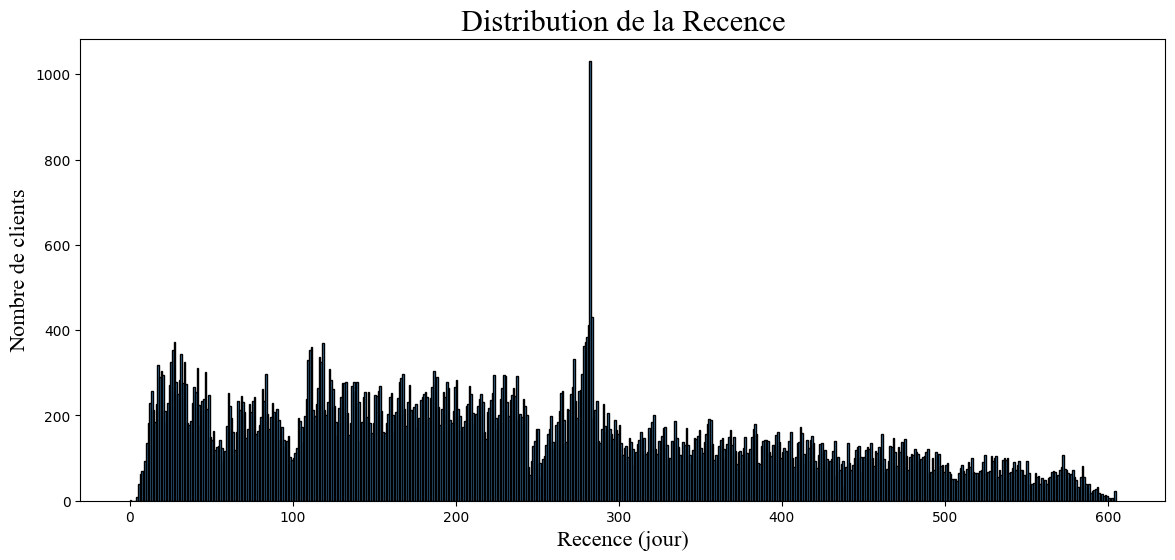

In [16]:
# Distribution de la récence
plt.figure(figsize=(14, 6))
plt.hist(
    df_data_filtered["recence"],
    bins=int(stats_filtered["max"]),
    color="steelblue",
    edgecolor="black",
)

# Titres du graphique et des axes
plt.xlabel("Recence (jour)", fontdict=font_axe)
plt.ylabel("Nombre de clients", fontdict=font_axe)
plt.title("Distribution de la Recence", fontdict=font_title)
plt.show()

Visualisons les dimensions du dataframe filtré.

In [17]:
# Affichage
display(df_data_filtered.head(3))
display(df_data_filtered.shape)

,recence,frequence,montant,satisfaction
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,4.0
0000f46a3911fa3c0805444483337064,541,1,86.22,3.0


(94427, 4)

## <span style='background:yellow; color:black'>2/ Détermination des plages temporelles</span>

Nous allons définir des plages temporelles pour réaliser notre analyse de
stabilité des segments au cours du temps. 

Nous avons fixé une **période de référence** d'1 an (365 jours) pour laquelle
nous avons réaliser notre **clustering de référence**. Il s'agit donc des
clients présentant une récence comprise entre 605 à 240 jours. Ensuite, nous
réaliserons un nouveau clustering **pour chaque semaine (7 jours)**. 

Voici une liste des plages temporelles:<br>
Plage_0 : période de référence d'1 an (365 jours).<br>
Plage_1 : période de référence + période comparative 1 semaine (372 jours)<br>
Plage_2 : période de référence + période comparative 2 semaines (379 jours)<br>
Plage_3 : période de référence + période comparative 3 semaines (386 jours)<br>
... etc<br>
Plage_34 : période de référence + période comparative 34 semaines (603 jours)<br>

In [18]:
# Nombre de jour des plages
nbr_jour_plage = 7

# Plage de référence (de + 365j après jusqu'au 1er jour)
plage_reference = (240, 605)

# Créer les plages
df_plages = creer_plages(plage_reference, nbr_jour_plage)

# Afficher le DataFrame
display(df_plages)

,jour_fin,jour_debut
0,240,605
1,233,605
2,226,605
3,219,605
4,212,605
5,205,605
6,198,605
7,191,605
8,184,605
9,177,605


## <span style='background:yellow; color:black'>3/ Création des datasets des plages temporelles</span>

Nous créons un dictionnaire qui contient les plages temporelles et les
datasets associés.

In [19]:
# Création des datasets des plages temporelles
datasets = creer_datasets(df_plages, df_data_filtered)

# Afficher les dimensions de tous les jeux de données
print("Dimensions des datasets :")
for key, dataset in datasets.items():
    print(f"{key}: {dataset.shape}")

Dimensions des datasets :
Plage_0: (42958, 4)
Plage_1: (44596, 4)
Plage_2: (46352, 4)
Plage_3: (47917, 4)
Plage_4: (49374, 4)
Plage_5: (50935, 4)
Plage_6: (52423, 4)
Plage_7: (54045, 4)
Plage_8: (55793, 4)
Plage_9: (57449, 4)
Plage_10: (58958, 4)
Plage_11: (60683, 4)
Plage_12: (62137, 4)
Plage_13: (63685, 4)
Plage_14: (65155, 4)
Plage_15: (66792, 4)
Plage_16: (68404, 4)
Plage_17: (70033, 4)
Plage_18: (71971, 4)
Plage_19: (73891, 4)
Plage_20: (75016, 4)
Plage_21: (75876, 4)
Plage_22: (77234, 4)
Plage_23: (78790, 4)
Plage_24: (80196, 4)
Plage_25: (81641, 4)
Plage_26: (82923, 4)
Plage_27: (83771, 4)
Plage_28: (85229, 4)
Plage_29: (86924, 4)
Plage_30: (88688, 4)
Plage_31: (90823, 4)
Plage_32: (92654, 4)
Plage_33: (94083, 4)
Plage_34: (94426, 4)


# <span style='background:blue'>Etape 2 : Clustering période de référence</span>

Nous créons donc un modèle KMeans avec 6 clusters.

In [20]:
# Données de travail
X = datasets["Plage_0"]

# Afficher X pour être sûr des données d'entrainement
display("Voici les données dans X :", X.head(3))
display(X.shape)

# Standardiser les données
scaler_ref = StandardScaler()
X_scaled = scaler_ref.fit_transform(X)

# Instancier l'estimateur
model_kmeans_ref = KMeans(n_init=10, random_state=42, n_clusters=6)

# Fit le modèle sur les données
model_kmeans_ref.fit(X_scaled)

'Voici les données dans X :'

,recence,frequence,montant,satisfaction
customer_unique_id,,,,
0000f46a3911fa3c0805444483337064,541,1,86.22,3.0
0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,4.0
0004aac84e0df4da2b147fca70cf8255,292,1,196.89,5.0


(42958, 4)

KMeans(n_clusters=6, n_init=10, random_state=42)

Nous concatenons les données avec les labels de cluster.

In [21]:
# Dataframe avec la feature des clusters
df_rfms_ref = pd.concat(
    [X, pd.Series(model_kmeans_ref.labels_, index=X.index, name="Cluster")],
    axis=1
)

# Affichage
display(df_rfms_ref.head(3))

,recence,frequence,montant,satisfaction,Cluster
customer_unique_id,,,,,
0000f46a3911fa3c0805444483337064,541,1,86.22,3.0,1
0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,4.0,0
0004aac84e0df4da2b147fca70cf8255,292,1,196.89,5.0,0


In [22]:
# Compter le nombre de lignes par cluster, trier les index et obtenir la
# proportion
cluster_counts = (
    df_rfms_ref["Cluster"]
    .value_counts(normalize=True)
    .sort_index()
)

# Convertir en pourcentage
cluster_counts_percentage = round(cluster_counts * 100, 1)

# Afficher les pourcentages
display(cluster_counts_percentage)

Cluster
0    46.6
1    32.9
2    15.4
3     0.1
4     3.3
5     1.7
Name: proportion, dtype: float64

Les proportions de chaque cluster sont du même ordre de grandeur que celles
obtenues dans le notebook 2 dont voici les proportion pour rappel : 
- Cluster 0 : 41.0%
- Cluster 1 : 16.2%
- Cluster 2 : 1.7%
- Cluster 3 : 31.2%
- Cluster 4 : 0.8%
- Cluster 5 : 9.1%

*Note : l'évolution des proportions de chaque cluster au cours du temps*
*serait très intructif pour mieux comprendre les comportements des clients.*
*Mais pour cela il faudrait inspecter le contenu de chaque cluster à chaque*
*clustering mais ce n'est pas l'objectif de ce notebook.*

# <span style='background:blue'>Etape 3 : Prédictions des clusters des nouveaux clients</span>

Chaque nouvelle semaine va impliquer l'ajout de nouveaux clients dans notre
analyse. Pour analyser la stabilité de notre clustering de référence,
**nous comparons les prédictions des clusters des nouveaux clients issues de**
**notre clustering de référence avec les prédictions des clusters des**
**nouveaux clients issues des clustering sur la même période**
(période de référence + nombre de semaine). 

## <span style='background:yellow; color:black'>1/ Prédictions à partir du modèle de référence</span>

En nous basant sur le clustering de référence, nous prédisons les clusters des
nouveaux clients pour chacune des 34 semaines de comparaison.

In [23]:
# Créer un dictionnaire pour stocker les datasets pour chaque plage de temps
dfs_predit = {}

# Parcourir toutes les plages dans le dictionnaire 'datasets'
for plage in datasets.keys():

    # SI période de référence alors on la copie
    if plage == "Plage_0":
        dfs_predit[plage] = df_rfms_ref

    else:
        # Données de travail
        X = datasets[plage]

        # Standardiser les données (transform ou fit_transform ?)
        X_scaled = scaler_ref.transform(X)

        # Prédire les clusters
        cluster_predit = model_kmeans_ref.predict(X_scaled)

        # Créer un DataFrame avec la feature des clusters
        df_predit = pd.concat(
            [X, pd.Series(cluster_predit, index=X.index, name="Cluster")],
            axis=1
        )

        # Stocker le DataFrame dans le dictionnaire 'dfs_predit'
        dfs_predit[plage] = df_predit

# Afficher les dimensions des datasets prédits
print("Dimensions des datasets avec clusters réel :")
for key, df in dfs_predit.items():
    print(f"{key}: {df.shape}")

Dimensions des datasets avec clusters réel :
Plage_0: (42958, 5)
Plage_1: (44596, 5)
Plage_2: (46352, 5)
Plage_3: (47917, 5)
Plage_4: (49374, 5)
Plage_5: (50935, 5)
Plage_6: (52423, 5)
Plage_7: (54045, 5)
Plage_8: (55793, 5)
Plage_9: (57449, 5)
Plage_10: (58958, 5)
Plage_11: (60683, 5)
Plage_12: (62137, 5)
Plage_13: (63685, 5)
Plage_14: (65155, 5)
Plage_15: (66792, 5)
Plage_16: (68404, 5)
Plage_17: (70033, 5)
Plage_18: (71971, 5)
Plage_19: (73891, 5)
Plage_20: (75016, 5)
Plage_21: (75876, 5)
Plage_22: (77234, 5)
Plage_23: (78790, 5)
Plage_24: (80196, 5)
Plage_25: (81641, 5)
Plage_26: (82923, 5)
Plage_27: (83771, 5)
Plage_28: (85229, 5)
Plage_29: (86924, 5)
Plage_30: (88688, 5)
Plage_31: (90823, 5)
Plage_32: (92654, 5)
Plage_33: (94083, 5)
Plage_34: (94426, 5)


## <span style='background:yellow; color:black'>2/ Prédictions à partir des modèles entrainés sur la plage correspondante</span>

Nous créons donc un modèle KMeans avec 6 clusters pour chacun des 34 semaines
de comparaison.

In [24]:
# Créer un dictionnaire pour stocker modèles et DataFrames pour chaque plage
models = {}
dfs_reel = {}

# Parcourir toutes les plages dans le dictionnaire 'datasets'
for plage in datasets.keys():

    # SI période de référence alors on la copie
    if plage == "Plage_0":
        dfs_reel[plage] = df_rfms_ref

    else:
        # Données de travail
        X = datasets[plage]

        # Standardiser les données
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Instancier l'estimateur
        model_kmeans = KMeans(n_init=10, random_state=42, n_clusters=6)

        # Fit le modèle sur les données
        model_kmeans.fit(X_scaled)

        # Stocker le modèle dans le dictionnaire 'models'
        models[plage] = model_kmeans

        # Prédire les clusters
        cluster_predit = model_kmeans.predict(X_scaled)

        # Créer un DataFrame avec la feature des clusters
        df_rfms = pd.concat(
            [X, pd.Series(cluster_predit, index=X.index, name="Cluster")],
            axis=1
        )

        # Stocker le DataFrame dans le dictionnaire 'dfs_reel'
        dfs_reel[plage] = df_rfms

# Afficher les dimensions des datasets réels
print("Dimensions des datasets avec clusters réel :")
for key, df in dfs_reel.items():
    print(f"{key}: {df.shape}")

Dimensions des datasets avec clusters réel :
Plage_0: (42958, 5)
Plage_1: (44596, 5)
Plage_2: (46352, 5)
Plage_3: (47917, 5)
Plage_4: (49374, 5)
Plage_5: (50935, 5)
Plage_6: (52423, 5)
Plage_7: (54045, 5)
Plage_8: (55793, 5)
Plage_9: (57449, 5)
Plage_10: (58958, 5)
Plage_11: (60683, 5)
Plage_12: (62137, 5)
Plage_13: (63685, 5)
Plage_14: (65155, 5)
Plage_15: (66792, 5)
Plage_16: (68404, 5)
Plage_17: (70033, 5)
Plage_18: (71971, 5)
Plage_19: (73891, 5)
Plage_20: (75016, 5)
Plage_21: (75876, 5)
Plage_22: (77234, 5)
Plage_23: (78790, 5)
Plage_24: (80196, 5)
Plage_25: (81641, 5)
Plage_26: (82923, 5)
Plage_27: (83771, 5)
Plage_28: (85229, 5)
Plage_29: (86924, 5)
Plage_30: (88688, 5)
Plage_31: (90823, 5)
Plage_32: (92654, 5)
Plage_33: (94083, 5)
Plage_34: (94426, 5)


# <span style='background:blue'>Etape 4 : Analyse de l'obsolescence du clustering</span>

## <span style='background:yellow; color:black'>1/ Calcul de l'ARI</span>

Nous utilisons la fonction **adjusted_rand_score** de la librairie
**sklearn.metrics** pour calculer l'ARI entre les clusters de la période de
référence et ceux des périodes de comparaison.

In [29]:
# Créer un dictionnaire pour stocker les scores ARI
ari_scores = {}

# Parcourir toutes les plages dans le dictionnaire 'dfs_reel'
for plage in dfs_reel.keys():

    # Trouvez les indices communs
    common_indices = (
        dfs_reel[plage].index.intersection(dfs_predit[plage].index)
    )

    # Filtrer les dataframes pour ne contenir que les indices communs
    df1_filtered = dfs_reel[plage].loc[common_indices]
    df2_filtered = dfs_predit[plage].loc[common_indices]

    # Calculer l'ARI
    ari = (
        adjusted_rand_score(df1_filtered["Cluster"], df2_filtered["Cluster"])
    )

    # Stocker le score ARI dans le dictionnaire 'ari_scores'
    ari_scores[plage] = ari

## <span style='background:yellow; color:black'>2/ Visualisation de l'ARI</span>

Nous affichons l'évolution de l'ARI au cours des 34 semaines de comparaison.

Nous définissions le seuil acceptable de l'ARI à **0,80**. En dessous de ce
seuil, le clustering de référence est obsolète.

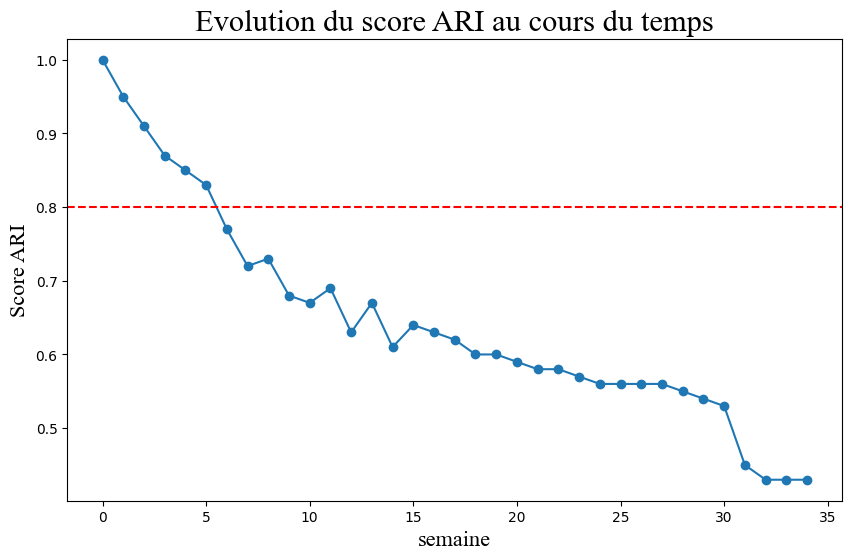

Le score ARI est en dessous du seuil de 0.8 à la semaine 6


In [26]:
# Définir le seuil
seuil = 0.80

# Extraire les scores ARI
scores = [round(score, 2) for score in ari_scores.values()]

# Création d'une liste de 0 a n, n étant le nombre de plage
semaine = np.arange(len(dfs_reel))

# Afficher le graphique de l'ARI
afficher_ARI(semaine, scores, seuil, font_title, font_axe)

# Afficher la semaine à partir de laquelle l'ARI tombe en dessous du seuil
for i, score in enumerate(scores):
    if score < seuil:
        message = (
            f"Le score ARI est en dessous du seuil de {seuil} "
            f"à la semaine {semaine[i]}"
        )
        print(message)
        break

# <span style='background:blue'>Conclusion</span>

La stabilité de notre clustering de K-means avec 6 clusters est de
**6 semaines**. Il faut donc réaliser un nouveau clustering toutes les 6
semaines (1,5 mois) pour que les segments soient stables.

In [27]:
# Afficher temps d'exécution du notebook
calculer_duree_notebook(start_time)

Durée totale pour faire tourner le notebook : 0 minute(s) 10 seconde(s)
